In [3]:
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from dotenv import dotenv_values
from datetime import date
from dateutil.relativedelta import relativedelta

In [6]:
# extract channel details
api_key = dotenv_values(".env")["API_KEY"]
# https://www.youtube.com/channel/UC0RhatS1pyxInC00YKjjBqQ
channel_id = "UC0RhatS1pyxInC00YKjjBqQ"
youtube = build("youtube", "v3", developerKey=api_key)

In [116]:
def channel_stats(youtube, channel_id):
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel_id
    )
    response = request.execute()
    return response

In [117]:
channel_stats(youtube, channel_id)

{'kind': 'youtube#channelListResponse',
 'etag': 'GWqn9GtyHBbNy7_Qg5693yZ0UKw',
 'pageInfo': {'totalResults': 1, 'resultsPerPage': 5},
 'items': [{'kind': 'youtube#channel',
   'etag': 'leAIt7YNi_-Hbu3KxRV42nAjWSk',
   'id': 'UC0RhatS1pyxInC00YKjjBqQ',
   'snippet': {'title': 'GeeksforGeeks',
    'description': 'Welcome to the official channel of GeeksforGeeks!\n\nOn our channel you will find hundreds of videos that will provide you with the insight and the knowledge to become an efficient coder. \n\nThese videos are inclusive of real life interview experiences of Geeks who are placed in product and service based companies, webinars and workshops with industry experts which are inclusive of a variety of topics pertaining to Computer Science and coding, informative videos and solutions to a variety of subjects and lastly, a music playlist for you Code Jamming sessions!\n\nSo come and make yourself comfortable in a world that always appreciates Geekiness!\n',
    'customUrl': '@geeksforg

### 1. Number of videos in the past 6 months from the start date. Must mention the dates in the solution.
#### Ans:
There are **201** videos uploaded in the last 6 months.
The video ids and dates are exported to ``./6_months_video.csv``

In [120]:
all_stats = channel_stats(youtube, channel_id)
main_info = all_stats["items"][0]
main_info

{'kind': 'youtube#channel',
 'etag': 'leAIt7YNi_-Hbu3KxRV42nAjWSk',
 'id': 'UC0RhatS1pyxInC00YKjjBqQ',
 'snippet': {'title': 'GeeksforGeeks',
  'description': 'Welcome to the official channel of GeeksforGeeks!\n\nOn our channel you will find hundreds of videos that will provide you with the insight and the knowledge to become an efficient coder. \n\nThese videos are inclusive of real life interview experiences of Geeks who are placed in product and service based companies, webinars and workshops with industry experts which are inclusive of a variety of topics pertaining to Computer Science and coding, informative videos and solutions to a variety of subjects and lastly, a music playlist for you Code Jamming sessions!\n\nSo come and make yourself comfortable in a world that always appreciates Geekiness!\n',
  'customUrl': '@geeksforgeeksvideos',
  'publishedAt': '2015-06-11T15:27:03Z',
  'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/ytc/AOPolaQyvtrOcl96BkPopaNOT67CByuuBS7Gqwi

In [142]:
# extract all videos
# id_all_vid = main_info["contentDetails"]["relatedPlaylists"]["uploads"]
playlist_all_id = main_info["contentDetails"]["relatedPlaylists"]["uploads"]
def get_video_in_channel(youtube, list_id):
    request = youtube.playlistItems().list(
        part="contentDetails",
        playlistId=list_id,
        maxResults=50
    )
    response = request.execute()
    video_ids, published_times = [], []
    for i in range(len(response["items"])):
        video_ids.append(response["items"][i]["contentDetails"]["videoId"])
        raw_time = response["items"][i]["contentDetails"]["videoPublishedAt"]
        published_time = datetime.fromisoformat(raw_time.replace("Z", "+00:00")).date()
        published_times.append(published_time)
    next_page_token = response.get("nextPageToken")
    more_pages = True
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part="contentDetails",
                        playlistId=list_id,
                        maxResults=50,
                        pageToken=next_page_token)
            response = request.execute()
            for i in range(len(response["items"])):
                video_ids.append(response["items"][i]["contentDetails"]["videoId"])
                raw_time = response["items"][i]["contentDetails"]["videoPublishedAt"]
                published_time = datetime.fromisoformat(raw_time.replace("Z", "+00:00")).date()
                published_times.append(published_time)
            next_page_token = response.get("nextPageToken")
    return video_ids, published_times
    # return response

In [143]:
playlist_all_id = main_info["contentDetails"]["relatedPlaylists"]["uploads"]
video_ids, published_times = get_video_in_channel(youtube, playlist_all_id)

In [150]:
# get the start date and end date in datetime format
current_date = datetime.today().date()
start_date = current_date - relativedelta(months=6)
# extract the published date between conditions
get_ids = [idx for idx in range(len(published_times)) if published_times[idx]>start_date and published_times[idx]<current_date]
print(f"The are {len(get_ids)} videos in the past 6 months") 
get_dates = [published_times[idx] for idx in get_ids]
get_video_ids = [video_ids[idx] for idx in get_ids]
pd.DataFrame({"Date": get_dates, "Video ID": get_video_ids}).to_csv("./6_months_video.csv", index=False)

The are 201 videos in the past 6 months


### 2. Create a pandas data frame with columns name as videos title, views, Length of videos, and videos link
#### Ans:
**Exported dataframe is store at** ``./videos_details.csv`` 

In [182]:
titles, views, lengths_vid, vid_links = [], [], [], []
for video_id in get_video_ids:
    request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=video_id
    )
    response = request.execute()
    titles.append(response["items"][0]["snippet"]["title"])
    views.append(response["items"][0]["statistics"]["viewCount"])
    lengths_vid.append(response["items"][0]["contentDetails"]["duration"].replace("PT", "").replace("H", ":").replace("M", ":").replace("S", ""))
    vid_links.append(f"https://www.youtube.com/watch?v={video_id}")
pd.DataFrame({"Videos title": titles, "Views": views, "Length of videos": lengths_vid, "Videos link": vid_links}).to_csv("./videos_details.csv", index=False)


### 3. Name the most viewed topics in the past 6 months.
#### Ans:
**Learn System Design with GeeksforGeeks** with **118340** views

In [197]:
Counts, titles = [], []
for video_id in get_video_ids:
    request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=video_id
    )
    response = request.execute()
    Counts.append(response["items"][0]["statistics"]["viewCount"])
    titles.append(response["items"][0]["snippet"]["title"])
df = pd.DataFrame({"Topics": titles, "Views": viewCounts})

In [220]:
views = list(df.Views)
views = [int(view) for view in views]
df.iloc[views.index(max(views)), 0], max(views)

('Learn System Design with GeeksforGeeks', 118340)

### 4. Name the topics with the highest video length.
### Ans:
**SDE Preparation in 3 hours** with 2.92 hours long.

In [242]:
df = pd.read_csv("./videos_details.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Videos title      201 non-null    object
 1   Views             201 non-null    int64 
 2   Length of videos  201 non-null    object
 3   Videos link       201 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB


In [243]:
lengths = [df.iloc[idx, 2] for idx in range(len(df))]
three_ele_idx = [idx for idx in range(len(lengths)) if len(lengths[idx].split(":"))==3] # global idx

In [258]:
total_secs = []
for idx in three_ele_idx:
    hour = int(lengths[idx].split(":")[0])*3600
    try:
        mins = int(lengths[idx].split(":")[1])*60
    except: mins = 0
    try:
        secs = int(lengths[idx].split(":")[2])
    except: secs==0
    total = hour + mins + secs
    total_secs.append(total)


In [261]:
total_secs.index(max(total_secs)) # the index with maximum lengths is 34
df.iloc[three_ele_idx[34], 0]

'SDE Preparation in 3 hours'

### 5. Make a comparison between the number of views and video length using a Graph.

In [270]:
df = pd.read_csv("./videos_details.csv")
# convert the lengths to minutes
lengths, views = [], []
for idx in range(len(df)):
    if len(df.iloc[idx, 2].split(":"))==2: # %m:%s
        mins = int(df.iloc[idx, 2].split(":")[0])*60
        try:
            secs = int(df.iloc[idx, 2].split(":")[1])
        except: secs = 0
        total = mins + secs
    elif len(df.iloc[idx, 2].split(":"))==3:
        hour = int(df.iloc[idx, 2].split(":")[0])*3600
        try:
            mins = int(df.iloc[idx, 2].split(":")[1])*60
        except: mins = 0
        try:
            secs = int(df.iloc[idx, 2].split(":")[2])
        except: secs==0
        total = hour + mins + secs       
        
    lengths.append(total)
    view = df.iloc[idx, 1]
    views.append(view)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


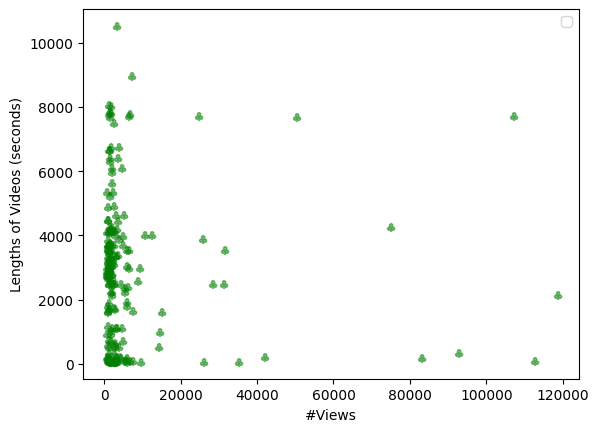

In [278]:
fig, ax = plt.subplots()
ax.scatter(views, lengths, c="green", alpha=0.5, marker=r'$\clubsuit$',
           label="")
ax.set_xlabel("#Views")
ax.set_ylabel("Lengths of Videos (seconds)")
ax.legend()
plt.show()